# Prototype - turn an env into a digraph
And display using d3ls force layout.


In [1]:
from flatland.envs.generators import rail_from_manual_specifications_generator
from flatland.envs.generators import random_rail_generator, complex_rail_generator
from flatland.envs.observations import TreeObsForRailEnv
from flatland.envs.rail_env import RailEnv
from flatland.utils.rendertools import RenderTool
from PIL import Image
import networkx as nx
import json
from numpy import array
import numpy as np
import pandas as pd
import random

## Create an env from a manual spec

In [2]:
specs = [[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)],
         [(0, 0), (0, 0), (0, 0), (0, 0), (7, 0), (0, 0)],
         [(7, 270), (1, 90), (1, 90), (1, 90), (2, 90), (7, 90)],
         [(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]]

env = RailEnv(width=6,
              height=4,
              rail_generator=rail_from_manual_specifications_generator(specs),
              number_of_agents=1,
              obs_builder_object=TreeObsForRailEnv(max_depth=2))

env.reset()

env_renderer = RenderTool(env, gl="PILSVG")
env_renderer.render_env(show=False)

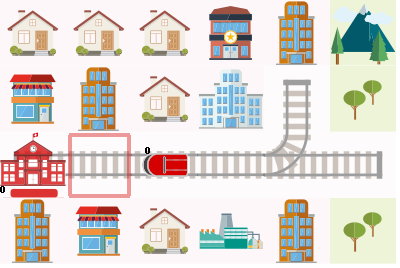

In [3]:
Image.fromarray(env_renderer.gl.get_image())

## Define some handy functions

In [4]:
# turn a transition into a string of binary
def trans_int_to_binstr(intTrans):
    sbinTrans = format(iTrans, "#018b")[2:]
    return "_".join(["NESW"[i] + sbinTrans[i*4:(i*4 + 4)] for i in range(0, 4)])

# Turn a transition into a 4x4 array of 0s and 1s
def trans_int_to_4x4(intTrans):
    arrBytes = np.array([intTrans >> 8, intTrans & 0xff], dtype=np.uint8)
    #print(arrBytes)
    arrBool = np.array(np.zeros((4,4)), dtype=np.bool)
    arrBool = np.unpackbits(arrBytes)
    arrBool4x4 = arrBool.reshape((4,4))
    return arrBool4x4

iTrans = env.rail.grid[2, 4]
i4x4 = trans_int_to_4x4(iTrans)
i4x4

array([[0, 0, 0, 0],
       [1, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1]], dtype=uint8)

In [5]:
# Turn a transition int into a string list, eg EE, EN, SW, WW
def trans_int_to_nesw(intTrans):
    astrNESW = np.array(list("NESW"))
    a2Trans = trans_int_to_4x4(intTrans)
    lstrTrans = [ np.char.add(astrNESW[iInDir], astrNESW[np.where(aiOutDirs)[0]])
                 for iInDir, aiOutDirs in enumerate(a2Trans) ]
    return ",".join(list(np.concatenate(lstrTrans)))

trans_int_to_nesw(iTrans)

'EN,EE,SW,WW'

### Table of transitions in various formats

In [6]:
ll = []
for rowcol, iTrans in np.ndenumerate(env.rail.grid):
    #print("{:} {:4} {} {} ".format(iCol, iTrans, trans_int_to_binstr(iTrans), trans_int_to_nesw(iTrans)))
    ll.append([rowcol, iTrans, trans_int_to_binstr(iTrans), trans_int_to_nesw(iTrans)])
df = pd.DataFrame(ll, columns=["rowcol", "Integer", "Binary", "NESW"])
df[df.Integer>0]

,rowcol,Integer,Binary,NESW
10,"(1, 4)",8192,N0010_E0000_S0000_W0000,NS
12,"(2, 0)",4,N0000_E0000_S0000_W0100,WE
13,"(2, 1)",1025,N0000_E0100_S0000_W0001,"EE,WW"
14,"(2, 2)",1025,N0000_E0100_S0000_W0001,"EE,WW"
15,"(2, 3)",1025,N0000_E0100_S0000_W0001,"EE,WW"
16,"(2, 4)",3089,N0000_E1100_S0001_W0001,"EN,EE,SW,WW"
17,"(2, 5)",256,N0000_E0001_S0000_W0000,EW


In [7]:
# Create a grid of nodes matching (isomorphic to) the env rail grid
G = nx.grid_2d_graph(*env.rail.grid.shape).to_directed()

In [8]:
G.nodes()

NodeView(((0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5)))

In [9]:
#G.edges()

## Functions to add nodes and edges from the env

In [10]:
# Add a node for each transition entrance, with id (row, col, dirIn, dirOut)
# (2, 4) 3089 N0000_E1100_S0001_W0001   EN,EE,SW,WW
# We have entry in directions E(1), S(2), W(3).
# (2,4,1) = E, (2,4,2) = S, (2,4,3) = W

gDirs = array([[-1,0], [0,1], [1,0], [0,-1]])

def add_entry_nodes(G, env):
    # Add entry nodes
    for rowcol, trans in np.ndenumerate(env.rail.grid):
        #print(rowcol, type(rowcol), trans, G.node[rowcol])
        b44 = trans_int_to_4x4(trans)
        for dirIn in range(4):
            if b44[dirIn].any(): # if we can enter in this direction
                G.add_node((*rowcol, dirIn), type="rail") # add a rail node for this entry
                G.add_edge(rowcol, (*rowcol, dirIn), type="hold") # add a hold edge to the grid node

In [11]:
def add_exit_edges(G, env):
    # add edges to the direction nodes
    for rcIn, trans in np.ndenumerate(env.rail.grid):
        #print(rowcol, type(rowcol), trans, G.node[rowcol])
        if trans > 0:
            b44 = trans_int_to_4x4(trans)

            for dirIn in range(4):
                for dirOut in range(4):
                    if b44[dirIn, dirOut]:
                        # get the rowcol of the destination cell
                        rcOut = tuple(array(rcIn) + gDirs[dirOut])
                        G.add_edge((*rcIn, dirIn), (*rcOut, dirOut), type="dir")



In [12]:
#G.nodes(data="type")

In [13]:
#G.edges(data="type")

### Function to save the graph as a json file for d3js

In [14]:
def savejson(g, sfName= "graph.json"):
    
    # d3 doesn't seem to like names like "(0, 1)" (stringified tuples) so use node indices
    # This is a dict from the tuple node id (row, col) to its (integer) index
    dNodeToIndex = { oNode:iNode for iNode, oNode in enumerate(g.nodes()) }
    
    
    ldNodes = [{'name': dNodeToIndex[oNode],
                'title': oNode,
                #"type": np.random.randint(2)
                "type": g.node[oNode].get("type")
               } for oNode in g.nodes() ]
    
    ldLinks = [{'source': dNodeToIndex[u[0]], 
                'target': dNodeToIndex[u[1]],
                #"type": len(u[1]),
                #"type": g.node[u[1]].get("type") # get the type of the node
                "type": g.edges[u].get("type") # get the type of the edge
               }  for u in g.edges()]
    
    djG = {'nodes': ldNodes, 'links': ldLinks}
    #print(json.dumps(djG))
    with open(sfName, 'w') as f:
        json.dump(djG, f, indent=4,)

In [15]:
pwd

'/home/jeremy/projects/aicrowd/rl-trains/flatland/notebooks'

### Create a grid of nodes for structure, then add the direction nodes and edges

In [16]:
# Create a grid of nodes matching (isomorphic to) the env rail grid
G = nx.grid_2d_graph(*env.rail.grid.shape).to_directed()
add_entry_nodes(G, env)
add_exit_edges(G, env)
savejson(G, "test1.json")

## HTML to display the graph using d3js and the local javascript file
The first time this notebook is run, this should pick up the simple manual env above.
Lower down, the json is replaced with a larger env.
So running this cell again, it should then display the larger env.  Typically you need to "shake" a few of the nodes to prolong the "simulation" which should allow the sheet of nodes to flatten out.  Initially it may also be inverted or rotated; again you can pull it around to make the usual env rendering.

In [17]:
%%html
<div id="d3-example"></div>
<script src="./render_graph_d3.js" />
<style>
.node {stroke: #fff; stroke-width: 1.5px;}
.link {stroke: #999; stroke-opacity: .6;}
</style>

## Try a larger env

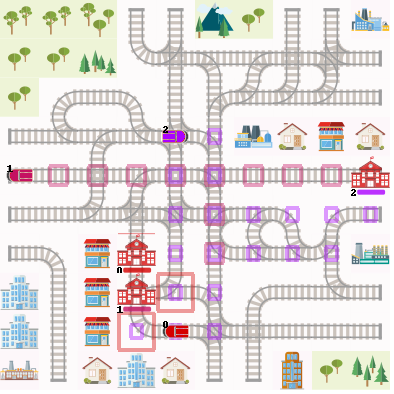

In [18]:
random.seed(102)
np.random.seed(102)

# Relative weights of each cell type to be used by the random rail generators.
transition_probability = [1.0,  # empty cell - Case 0
                          1.0,  # Case 1 - straight
                          1.0,  # Case 2 - simple switch
                          0.3,  # Case 3 - diamond drossing
                          0.5,  # Case 4 - single slip
                          0.5,  # Case 5 - double slip
                          0.2,  # Case 6 - symmetrical
                          0.0,  # Case 7 - dead end
                          0.2,  # Case 8 - turn left
                          0.2,  # Case 9 - turn right
                          1.0]  # Case 10 - mirrored switch

# Example generate a random rail
env = RailEnv(width=10,
              height=10,
              rail_generator=random_rail_generator(cell_type_relative_proportion=transition_probability),
              # rail_generator=complex_rail_generator(nr_start_goal=3, min_dist=5),
              number_of_agents=3,
              obs_builder_object=TreeObsForRailEnv(max_depth=2))

env.reset()

env_renderer = RenderTool(env, gl="PILSVG")
env_renderer.render_env(show=False)
Image.fromarray(env_renderer.gl.get_image())

In [19]:
# Create a grid of nodes matching (isomorphic to) the env rail grid
G = nx.grid_2d_graph(*env.rail.grid.shape).to_directed()
add_entry_nodes(G, env)
add_exit_edges(G, env)
savejson(G, "test1.json")
